# Lab 2 - Tokenization Efficiency Benchmark

"The goal of this assignment is to analyze how different tokenization strategies influence the performance and behavior of a language model."

In [1]:
import os
import time
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd

import config
from tokenizer import ensure_pretrained_tokenizer, ensure_whitespace_tokenizer, ensure_spm_tokenizer, SPMTokenizer
from model import TransformerDecoderOnly
from data import LanguageModelDataset
from train import train_epoch, evaluate

print(f"Running on device: {config.DEVICE}")

Running on device: cpu


Defining data paths and getting the amount of lines to read from files to ensure ~1MB of text. The tokenizers and the models were trained using `wolne_lektury_corpus` and validated using `1000_novels_corpus_CLARIN-PL` (only high-quality docs were used)

In [2]:
train_data_path = os.path.join(config.DATA_DIR, config.TRAIN_FILE)
valid_data_path = os.path.join(config.DATA_DIR, config.VALID_FILE)

In [3]:
def get_lines_for_size(filepath, target_mb=1.0):
    target_bytes = target_mb * 1024 * 1024
    current_bytes = 0
    line_count = 0
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            current_bytes += len(line.encode('utf-8'))
            line_count += 1
            if current_bytes >= target_bytes:
                break
                
    return line_count, current_bytes / (1024 * 1024)

train_file = train_data_path
valid_file = valid_data_path

t_lines, t_size = get_lines_for_size(train_file, target_mb=1.0)
print(f"\nTraining File:   {train_file}")
print(f"Lines needed:    {t_lines}")
print(f"Actual size:     {t_size:.4f} MB")

v_lines, v_size = get_lines_for_size(valid_file, target_mb=1.0)
print(f"\nValidation File: {valid_file}")
print(f"Lines needed:    {v_lines}")
print(f"Actual size:     {v_size:.4f} MB")


Training File:   /home/julia/Documents/lingwistyka/computational-linguistics/data/lektury_train.txt
Lines needed:    18226
Actual size:     1.0000 MB

Validation File: /home/julia/Documents/lingwistyka/computational-linguistics/data/prose_val.txt
Lines needed:    21926
Actual size:     1.0001 MB


Later in the assignment 25000 was used as the number of lines to process. 

In [5]:
MAX_LINES = 25000

### Pre-trained tokenizer
- A wrapper function was prepared in `tokenizer.py` to ensure the code written for the previous assignment works. 
- The chosen model was `mistralai/Mistral-7B-v0.1`. This is because it has a smaller vocabulary size than the suggested GPT-2 BPE, so the model will be smaller - less expensive to train.
- After importing `from transformers import AutoTokenizer` it can be loaded with `AutoTokenizer.from_pretrained(model_name)`

In [6]:
tok_pre = ensure_pretrained_tokenizer() # config.PRETRAINED_MODEL_NAME set to "mistralai/Mistral-7B-v0.1"
print("Vocab size:", tok_pre.get_vocab_size())

Vocab size: 32001


### Whitespace-based tokenizer (custom implementation)
- splits text on whitespace and keeps punctuation as separate tokens:
    
    ```
    TOKEN_PATTERN = re.compile(r"\w+|[^\w\s]", flags=re.UNICODE) # one or more “word characters” OR a single character that is not a word or a whitespace
    ```
    
- uses top-N most frequent tokens from the training corpus
- everything else goes to `<UNK>`

In [7]:
tokenizer_path = os.path.join(config.TOKENIZER_DIR, "whitespace_tokenizer")
tok_wspc = ensure_whitespace_tokenizer(train_data_path, tokenizer_path, vocab_size=tok_pre.get_vocab_size())

print("Vocab size: ", tok_wspc.get_vocab_size())

Vocab size:  32001


### SentencePiece tokenizer 

-   Trained using the **Unigram** algorithm (not BPE)
-   `character_coverage=1.0`: Configured to include all characters from the training corpus.
-   **OOV handling** - trained with `byte_fallback=False`.
    Modern tokenizers often use byte fallback to theoretically achieve 0% OOV. By disabling this, the tokenizer is "forced" to output the `<unk>` when it encounters unknown subwords. The <unk> token is displayed as "??" by default for SentencePiece

In [8]:
tokenizer_path = os.path.join(config.TOKENIZER_DIR, "sentence-piece")
tok_spm = ensure_spm_tokenizer(train_data_path, tokenizer_path, vocab_size=tok_pre.get_vocab_size())

print("Vocab size: ", tok_spm.get_vocab_size())

Vocab size:  32001


### Model training for each tokenizer

Model architecture and hyperparameters

In [8]:
dummy_model = TransformerDecoderOnly(
    vocab_size=tok_pre.get_vocab_size(),
    d_model=config.TX_D_MODEL,
    n_layer=config.TX_N_LAYER,
    n_head=config.TX_N_HEAD,
    d_ff=config.TX_D_FF,
    dropout=config.TX_DROPOUT,
    pad_id=0
)
print(dummy_model)
print(f"Total Parameters: {sum(p.numel() for p in dummy_model.parameters()):,}")

TransformerDecoderOnly(
  (embed): Embedding(32001, 128, padding_idx=0)
  (posenc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-3): 4 x DecoderBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=32001, bias=False)
)
Total Parameters: 5,415,808


In [9]:
import matplotlib.pyplot as plt

experiments = [
    {"name": "Pretrained",    "tok": tok_pre,  "ckpt": "best_tx_pre.pth"},
    {"name": "Whitespace",    "tok": tok_wspc, "ckpt": "best_tx_wspc.pth"},
    {"name": "SentencePiece", "tok": tok_spm,  "ckpt": "best_tx_spm.pth"}
]

# dict to store full training history for plots
history = {exp['name']: {'train_loss': [], 'val_ppl': []} for exp in experiments}
training_logs = []

EPOCHS = 10

for exp in experiments:
    print(f"\n=============================================")
    print(f"Training Model with: {exp['name']} Tokenizer")
    print(f"=============================================")
    
    model = TransformerDecoderOnly(
        vocab_size=exp['tok'].get_vocab_size(),
        d_model=config.TX_D_MODEL,
        n_layer=config.TX_N_LAYER,
        n_head=config.TX_N_HEAD,
        d_ff=config.TX_D_FF,
        dropout=config.TX_DROPOUT,
        pad_id=exp['tok'].pad_id
    ).to(config.DEVICE)
    
    train_ds = LanguageModelDataset(train_data_path, exp['tok'], config.SEQ_LEN, MAX_LINES)
    valid_ds = LanguageModelDataset(valid_data_path, exp['tok'], config.SEQ_LEN, MAX_LINES)
    
    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_ds, batch_size=config.BATCH_SIZE, drop_last=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=exp['tok'].pad_id)
    save_path = os.path.join(config.CHECKPOINT_DIR, exp['ckpt'])
    
    total_train_time = 0
    best_ppl = float('inf')

    for epoch in range(EPOCHS):
        t0 = time.time()
        train_loss, _ = train_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_loss, val_ppl = evaluate(model, valid_loader, criterion, config.DEVICE)
        dt = time.time() - t0
        total_train_time += dt
        
        history[exp['name']]['train_loss'].append(train_loss)
        history[exp['name']]['val_ppl'].append(val_ppl)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.3f} | Val PPL: {val_ppl:.3f} | Time: {dt:.1f}s")
        
        if val_ppl < best_ppl:
            best_ppl = val_ppl
            torch.save(model.state_dict(), save_path)
    
    training_logs.append({
        "Tokenizer": exp['name'],
        "Training Time (s)": round(total_train_time, 2),
        "Batches/Epoch": len(train_loader)
    })

print("\nTraining Complete.")


Training Model with: Pretrained Tokenizer
  Batch 100/621, Loss: 13.2913
  Batch 200/621, Loss: 7.7154
  Batch 300/621, Loss: 6.5977
  Batch 400/621, Loss: 5.6782
  Batch 500/621, Loss: 5.5987
  Batch 600/621, Loss: 5.3516
  > Train Epoch Time: 146.50s
Epoch 1/10 | Train Loss: 9.322 | Val PPL: 187.187 | Time: 187.8s
  Batch 100/621, Loss: 5.6768
  Batch 200/621, Loss: 5.4076
  Batch 300/621, Loss: 5.0102
  Batch 400/621, Loss: 4.8777
  Batch 500/621, Loss: 4.8400
  Batch 600/621, Loss: 4.9682
  > Train Epoch Time: 146.22s
Epoch 2/10 | Train Loss: 5.141 | Val PPL: 110.384 | Time: 188.6s
  Batch 100/621, Loss: 4.5342
  Batch 200/621, Loss: 4.5397
  Batch 300/621, Loss: 4.8878
  Batch 400/621, Loss: 4.7429
  Batch 500/621, Loss: 4.8036
  Batch 600/621, Loss: 4.4749
  > Train Epoch Time: 146.91s
Epoch 3/10 | Train Loss: 4.738 | Val PPL: 85.587 | Time: 190.4s
  Batch 100/621, Loss: 4.5967
  Batch 200/621, Loss: 4.5093
  Batch 300/621, Loss: 4.4711
  Batch 400/621, Loss: 4.6270
  Batch 500/

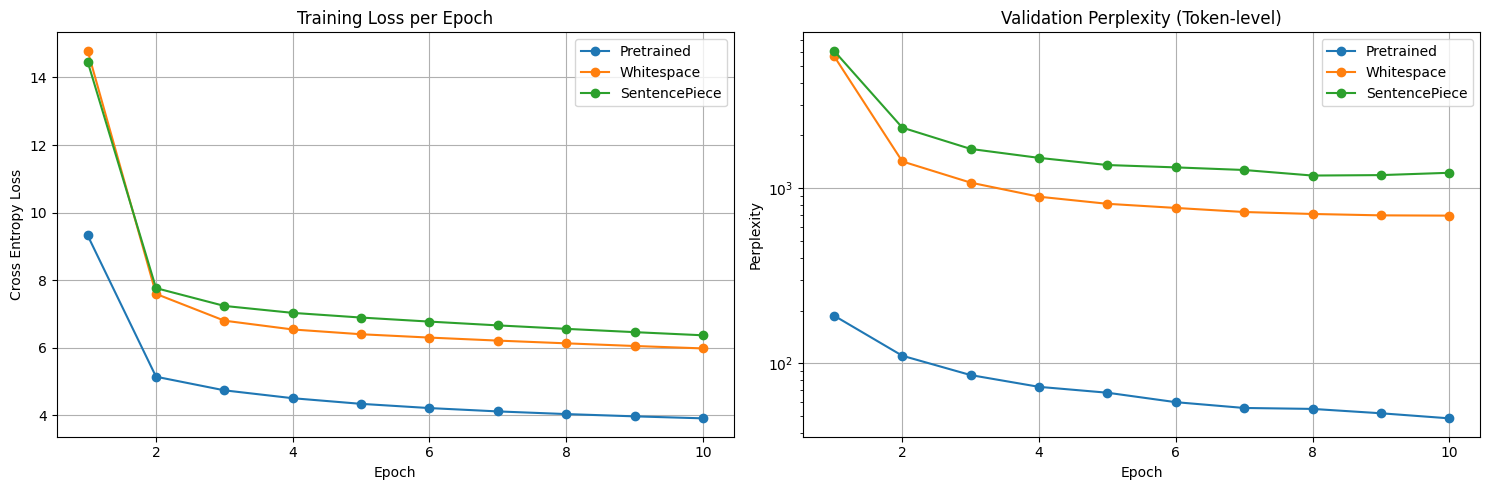

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, data in history.items():
    axes[0].plot(range(1, EPOCHS+1), data['train_loss'], marker='o', label=name)
axes[0].set_title("Training Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].legend()
axes[0].grid(True)

for name, data in history.items():
    axes[1].plot(range(1, EPOCHS+1), data['val_ppl'], marker='o', label=name)
axes[1].set_title("Validation Perplexity (Token-level)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Perplexity")
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

- Even though the token-lvl PPL was not supposed to be reported - it was plotted here to check the models' generalisation and for a sanity-check if the models were not overfitting.
- Both the training loss and validation PPL are dropping which means the models are learning. 

### Quantitive analysis

In [ ]:
from benchmark_utils import calculate_metrics
results = []

for exp in experiments:
    ckpt_path = os.path.join(config.CHECKPOINT_DIR, exp['ckpt'])
    
    model = TransformerDecoderOnly(
        vocab_size=exp['tok'].get_vocab_size(),
        d_model=config.TX_D_MODEL,
        n_layer=config.TX_N_LAYER,
        n_head=config.TX_N_HEAD,
        d_ff=config.TX_D_FF,
        dropout=config.TX_DROPOUT,
        pad_id=exp['tok'].pad_id
    ).to(config.DEVICE)
    
    try:
        model.load_state_dict(torch.load(ckpt_path, map_location=config.DEVICE, weights_only=True))
    except FileNotFoundError:
        print(f"Warning: Checkpoint not found for {exp['name']}")
        continue

    ds = LanguageModelDataset(valid_data_path, exp['tok'], config.SEQ_LEN, MAX_LINES)
    loader = DataLoader(ds, batch_size=config.BATCH_SIZE, drop_last=True)
    
    metrics = calculate_metrics(model, exp['tok'], loader, valid_data_path, max_lines=MAX_LINES)
    
    train_stat = next((item for item in training_logs if item["Tokenizer"] == exp['name']), None)
    if train_stat:
        metrics['Train Time (s)'] = train_stat['Training Time (s)']
        metrics['Batches/Epoch'] = train_stat['Batches/Epoch']
    
    metrics['Tokenizer'] = exp['name']
    results.append(metrics)

df_results = pd.DataFrame(results)

cols = [
    'Tokenizer', 'word_ppl', 'char_ppl', 
    'oov_rate', 'oov_count', 
    'tokens_per_word', 'tokenizer_speed', 
    'Train Time (s)', 'Batches/Epoch'
]

cols = [c for c in cols if c in df_results.columns]

display(df_results[cols])

,Tokenizer,word_ppl,char_ppl,oov_rate,oov_count,tokens_per_word,tokenizer_speed,Train Time (s),Batches/Epoch
0,Pretrained,91761.121119,5.856381,0.000000,0,2.945383,6.371229e+05,1930.67,621
1,Whitespace,2507.497267,3.355816,8.751417,18068,1.199340,3.446920e+06,761.94,257
2,SentencePiece,54044.094952,5.395932,4.850430,12889,1.543653,2.181208e+06,1007.03,342


**Perplexity and OOV metrics**
- the whitespace tokenizer has the lowest word-level PPL and character-level PPL; followed by the SentencePiece tokenizer; with Mmistral pre-trained tokenizer having both PPLs the highest
- However the low PPL score for whitespace is misleading since it also has an **OOV Rate of 8.7%**. Nearly 1 in 10 words was replaced by `<UNK>`. Since predicting the `<UNK>` token is mathematically easier than predicting a specific rare word (like "chrząszcz"), the model minimized its loss by "giving up" on complex vocabulary. 
- It can be concluded that PPL is only a valid comparison metric when vocabulary coverage is similar.

**Tokenization efficiency (tok / word)**
- whitespace has the most efficient storage (1 word ~ 1 token), but limited vocabulary. 
- pre-trained has the least efficient storage. It breaks Polish words into many small subwords (e.g., "przebijały" - 5 tokens) - this can be seen below in the Qualitative Analysis. 
- This was expected as the Mistral tokenizer was trained largely on English, so the tokenizer is less optimal for Polish morphology.
- SentencePiece is a middle ground. By training on the specific *lektury* corpus, it learned subwords relevant to this domain, resulting in better compression than Mistral.

**Tokenizer throughput**
- The whitespace tokenizer is the quickest, producing ~3.4M tokens per second; followed by SentencePIece ~2.2M; followed by pre-trained 0.6M
- This makes sense as it follows the simplest rules for splitting the text, while SentencePiece and pre-trained both use more advanced probabilistic models for tokenization
- pre-trained could also be the slowest due to software overheaad caused by using AutoTokenizer

**Training time, batch size and context**
- All three models used the same architecture and varied only by the tokenizer. Becuase the tokenizers result in the text being split in different amounts of tokens the training times and number of batches differ
- This also means that the model with the pre-trained tokenizer "sees" less context per sample - so it could result in it not being able to allow for a context reaching as far back as the other models  

### Qualitative analysis

In [ ]:
samples = [
    "W ciemnym i gęstym lesie, gdzie promienie słoneczne z trudem przebijały się przez korony drzew, wędrowiec zatrzymał się, by nasłuchiwać śpiewu ptaków, który niósł się echem pośród starych dębów i sosen.",
    "In a dark and dense forest, where rays of sunlight struggled to pierce through the tree canopy, a wanderer stopped to listen to the birdsong echoing among the old oaks and pines.",
    "Współczesne systemy sztucznej inteligencji, oparte na głębokich sieciach neuronowych, potrafią przetwarzać ogromne ilości danych w czasie rzeczywistym, co pozwala na automatyzację procesów, które jeszcze dekadę temu wymagały pracy wielu specjalistów.",
    "Raport finansowy za rok 2024 wskazuje, że #inflacja spadła poniżej 3.5%, co jest sygnałem stabilizacji rynku; jednakże analitycy z WallStreet ostrzegają przed nadmiernym optymizmem w sektorze technologicznym i kryptowalut."
]

print("--- QUALITATIVE TOKENIZATION COMPARISON ---")

for i, text in enumerate(samples):
    print(f"\nSAMPLE {i+1}: \"{text}\"")
    words = text.split()
    print(f"Word count: {len(words)}")
    print("-" * 60)
    
    for exp in experiments:
        tok = exp['tok']
        name = exp['name']
        
        ids = tok.encode(text, add_bos_eos=False)
        
        decoded_tokens = []
        if hasattr(tok, "sp"): 
             decoded_tokens = [tok.sp.id_to_piece(id) for id in ids]
        elif hasattr(tok, "tok"): 
            decoded_tokens = tok.tok.convert_ids_to_tokens(ids)
        elif hasattr(tok, "idx_to_token"): 
            decoded_tokens = [tok.idx_to_token[id] if id < len(tok.idx_to_token) else "<UNK>" for id in ids]
            
        # calculate % encoded directly
        # encoded as exactly 1 token and not replaced by UNK
        direct_count = 0
        for w in words:
            w_ids = tok.encode(w, add_bos_eos=False)
            if len(w_ids) == 1:
                # Check if that single token is UNK
                unk_id = getattr(tok, "unk_id", -1)
                if w_ids[0] != unk_id:
                    direct_count += 1
        
        direct_pct = (direct_count / len(words)) * 100

        print(f"[{name}]")
        print(f"   Tokens: {decoded_tokens}")
        print(f"   Count:  {len(ids)}")
        print(f"   Ratio:  {len(ids)/len(words):.2f} tokens/word")
        print(f"   Direct: {direct_pct:.1f}% (words encoded directly)")
        
        # check for UNKs in whitespace
        if name == "Whitespace":
            unk_count = ids.count(tok.unk_id)
            if unk_count > 0:
                print(f"   UNKs:   {unk_count} (words not in dictionary)")

--- QUALITATIVE TOKENIZATION COMPARISON ---

SAMPLE 1: "W ciemnym i gęstym lesie, gdzie promienie słoneczne z trudem przebijały się przez korony drzew, wędrowiec zatrzymał się, by nasłuchiwać śpiewu ptaków, który niósł się echem pośród starych dębów i sosen."
Word count: 31
------------------------------------------------------------
[Pretrained]
   Tokens: ['▁W', '▁c', 'iem', 'nym', '▁i', '▁g', 'ę', 'st', 'ym', '▁les', 'ie', ',', '▁g', 'dzie', '▁prom', 'ien', 'ie', '▁s', 'ł', 'one', 'cz', 'ne', '▁z', '▁tr', 'ud', 'em', '▁prz', 'eb', 'ij', 'ał', 'y', '▁się', '▁przez', '▁kor', 'ony', '▁dr', 'z', 'ew', ',', '▁w', 'ęd', 'row', 'ie', 'c', '▁z', 'atr', 'zy', 'ma', 'ł', '▁się', ',', '▁by', '▁nas', 'ł', 'uch', 'i', 'wa', 'ć', '▁ś', 'p', 'iew', 'u', '▁pt', 'ak', 'ów', ',', '▁który', '▁n', 'ió', 's', 'ł', '▁się', '▁e', 'chem', '▁po', 'ś', 'r', 'ód', '▁st', 'ary', 'ch', '▁d', 'ę', 'b', 'ów', '▁i', '▁s', 'osen', '.']
   Count:  89
   Ratio:  2.87 tokens/word
   Direct: 29.0% (words encoded direct

**Observations**
- there were 3 differeent sentences provided to check how the tokenizers behave based on whether the example is similar to what could have been found in the trianing corpus or not 
- for the first sample which was similar to the training corpus it could be observed that whitespace and SentencePiece behaved similarly, but pre-trained used almost 3 times more tokens - which means it couldn't capture the words as efficiently
- since after seeing the results I hypothesised that for the pre-trained Mistral tokenizer the tokens/word ratio is much bigger because it was trained largely on an English corpus - I wanted to check if in fact it would result in a smaller number of tok/work for an English sample. It did which supports the hypothesis 
- **a "universal" tokenizer like Mistral is efficient for English but computationally expensive for Polish.**
- For the second sample the drawbacks of whitespace are clearl visible - since the text is different to what could have appeared in the training corpus the tokenizer fails to find representations of a lot of words ~30%, the situation is even worse for the last sample where there were additionally numbers and special characters involved
- SentencePiece performed better than whitespace on these two samples (not that many oov tokens), although the number of tokens needed per word increased compared to the first sample (which makes sense since the words were less probable to have appeared in the training corpus)

### Generation

In [ ]:
from generate import generate_text
import time

prompt = "Dawno temu w odległej krainie" 
gen_len = 200
print(f"--- GENERATION (Prompt: '{prompt}') ---\n")

for exp in experiments:
    
    model = TransformerDecoderOnly(
        vocab_size=exp['tok'].get_vocab_size(),
        d_model=config.TX_D_MODEL,
        n_layer=config.TX_N_LAYER,
        n_head=config.TX_N_HEAD,
        d_ff=config.TX_D_FF,
        dropout=config.TX_DROPOUT,
        pad_id=exp['tok'].pad_id
    ).to(config.DEVICE)
    
    ckpt_path = os.path.join(config.CHECKPOINT_DIR, exp['ckpt'])
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=config.DEVICE, weights_only=True))
    else:
        print(f"Warning: {ckpt_path} not found.")
        continue

    t0 = time.time()
    generated = generate_text(model, exp['tok'], prompt, max_len=gen_len, temperature=0.8)
    dt = time.time() - t0
    
    speed = gen_len / dt
    
    print(f"[{exp['name']}] Speed: {speed:.2f} tokens/sec")
    print(f"OUTPUT:\n{generated}\n")
    print("-" * 60)

--- GENERATION (Prompt: 'Dawno temu w odległej krainie') ---

False
[Pretrained] Speed: 94.14 tokens/sec
OUTPUT:
Dawno temu w odległej krainie, której wolna,
ażą, co się u nim skromzin,
ten ciała, gdzie myślą, ciemnych nie w gwiazdy.
  Więc życzka ta tak w wykroć z łaskawach
Złotących nie mnie wiosliwiadł na nocząc więc, gorok.
I w skrużułagodziecięte, nie wstą, wicha pojęli się nawały wyrastem tylko, różka jest łonią był woda nocyjmukoszczyzuty twym Jutam się niebianki. Kilkiego, zajmujeżka,
wiony,y się rozk, pał, w róż w w główczas,

------------------------------------------------------------
False
[Whitespace] Speed: 116.28 tokens/sec
OUTPUT:
Dawno temu w odległej krainie opowiada <UNK>. » I w <UNK> w <UNK> na <UNK>, gdzie ach, I <UNK> <UNK>, <UNK> ani <UNK> I Wiatr ogrody, zamiar jak <UNK> <UNK> <UNK>, <UNK>, <UNK> innego i jak <UNK> <UNK>, <UNK>, <UNK> w <UNK> <UNK>. Ta <UNK> w <UNK> <UNK>. I <UNK> <UNK>. Nic nie <UNK> <UNK>— <UNK>: Więc Syrena I dla piach z nią na ze mną karty <

**Inference time**
- Inference is similar for whitespace and SentencePiece (varying by runs), the model that uses the pre-trained tokenizer "produces" less tokens / sec probably due to software overhead agin, since the architectures are the same apart from the used tokenizers

**Generated text quality**
- **whitespace** usage doesn't make sense for this task, as the output is dominated by <unk> tokens
- the output of the model using pre-trained seems better readable than the one by SentencePiece
- training a larger model and on a larger corpus would be necessary to start obtaining more meaningful output generation

**Final conclusion:** It's worth training the tokenizer on the corpus for which we want it to be calibrated since we can then obtain a tokenizer that uses less tokens/word which - given the same model architecture - could outperform a tokenizer that wasn't trained using a particular corpus - by "seeing" a larger context and also training faster. So if our target is using the model for Polish - it is better to use a tokenizer that was trained on polish, rather than mostly English.